# Reccomendation System for Steam Game - Content-Based Filtering

- Author    : Muhammad Aditya Bayhaqie
- Practice  : Machine Learning Terapan (Dicoding)
- Dataset   : [Steam Games Kaggle](https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/data?select=games.csv)

## Data Understanding

Mari panggil library dan dataset yang akan digunakan.

In [59]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!cp /content/drive/MyDrive/CollabData/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# !kaggle datasets download fronkongames/steam-games-dataset

In [7]:
# !unzip steam-games-dataset.zip

### Data Assessment

In [8]:
games = pd.read_csv('/content/games.csv')

In [9]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111452 entries, 20200 to 3183790
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AppID                       111446 non-null  object 
 1   Name                        111452 non-null  object 
 2   Release date                111452 non-null  object 
 3   Estimated owners            111452 non-null  int64  
 4   Peak CCU                    111452 non-null  int64  
 5   Required age                111452 non-null  float64
 6   Price                       111452 non-null  int64  
 7   DiscountDLC count           111452 non-null  int64  
 8   About the game              104969 non-null  object 
 9   Supported languages         111452 non-null  object 
 10  Full audio languages        111452 non-null  object 
 11  Reviews                     10624 non-null   object 
 12  Header image                111452 non-null  object 
 13  Website       

Dari data tersebut, ditarik kesimpulan bahwa:
- Terdapat 37 **Kolom**
- Terdapat 111452 **Baris**
- Beberapa Kolom memiliki **Non-null** yang sedikit (`Score rank`, `Metacritic url`, `Reviews`) dan perlu ditangani dengan beberapa metode berupa
  - Drop Kolom
  - Isi Kolom kosong

In [10]:
# Membaca dataset

df = games
df.head(5)

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


Dari data tersebut, Dapat disimpulkan bahwa Terjadi pergeseran konten data dari kolom `AppID` hingga `DiscountDLCcount`, `AppID` akan di drop karena data tersebut Insignifikan dan Kolom lainnya akan direname untuk memperbaiki konten data

### Data Preparation

In [11]:
# Rename columns
df = df.rename(columns={
    'Price': 'DiscountDLC count',
    'Required age' : 'Price',
    'Peak CCU': 'Required age',
    'Estimated owners': 'Peak CCU',
    'Release date': 'Estimated owners',
    'Name': 'Release date',
    'AppID': 'Name',
})

# Reindex the DataFrame
df = df.reset_index(drop=True)

df.head(5)

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [12]:
# Drop the 8th column ('DiscountDLC count')
df = df.drop(df.columns[7], axis=1)

# Display the updated DataFrame (optional)
df.head(5)

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Reviews,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],[],NaN,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],NaN,...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],NaN,...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


## Exploratory Data Analysis

### Univariate Exploratory Data Analysis

`Game` Variable

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111452 entries, 0 to 111451
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Name                        111446 non-null  object 
 1   Release date                111452 non-null  object 
 2   Estimated owners            111452 non-null  object 
 3   Peak CCU                    111452 non-null  int64  
 4   Required age                111452 non-null  int64  
 5   Price                       111452 non-null  float64
 6   About the game              104969 non-null  object 
 7   Supported languages         111452 non-null  object 
 8   Full audio languages        111452 non-null  object 
 9   Reviews                     10624 non-null   object 
 10  Header image                111452 non-null  object 
 11  Website                     46458 non-null   object 
 12  Support url                 50759 non-null   object 
 13  Support email 

Fitur `Release date` perlu diganti tipe datanya ke dates agar datanya dapat meproses masukan data lebih baik nantinya

In [14]:
print('Banyak data game yang terdaftar: ', len(df.Name.unique()))
print('Banyak game yang terdaftar: ', df.Name.unique())
print('List Game: ', df.Name.unique())

Banyak data game yang terdaftar:  110326
Banyak game yang terdaftar:  ['Galactic Bowling' 'Train Bandit' 'Jolt Project' ... 'MosGhost'
 'AccuBow VR' 'Defense Of Fort Burton']
List Game:  ['Galactic Bowling' 'Train Bandit' 'Jolt Project' ... 'MosGhost'
 'AccuBow VR' 'Defense Of Fort Burton']


Terdapat 110326 data Game yang unik dengan 37 Fitur yang dapat digunakan

## Data Preprocessing

## Data Preparation

### Taking care on Missing Values

In [15]:
# Mengecek missing value pada dataframe all_resto
df.isnull().sum()

,0
Name,6
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,6483
Supported languages,0
Full audio languages,0
Reviews,100828


#### `Name` Feature Treatment

Feature `Name` yang null akan didrop saja barisnya.

In [16]:
df.dropna(subset=['Name'], inplace=True)
df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,6478
Supported languages,0
Full audio languages,0
Reviews,100822


#### `About the game` Feature Treatment

Feature `About the game` akan diganti dengan data

```
No Description
```

In [17]:
df['About the game'] = df['About the game'].fillna('No Description')
df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Reviews,100822


#### `Reviews`, `Website`, `Support url`, `Support email`, `Metacritic url`, `Metacritic score`, `Average playtime two weeks`,`Median playtime two weeks`, `Score rank` and `Notes` Feature Treatment

Fitur `Reviews`, `Website`, `Support url`, `Support email`, `Metacritic url`, `Metacritic score`, `Average playtime two weeks`,`Median playtime two weeks`, `Score rank` dan `Notes` akan didrop saja kolomnya

*PS: Data ini dapat digunakan sebagai pelengkap deskripsi game yang akan kita rekomendasikan, namun untuk kali ini datanya akan didrop saja*

In [18]:
# Drop specified columns
columns_to_drop = ['Reviews', 'Website', 'Support url', 'Support email', 'Metacritic url' , 'Metacritic score' , 'Score rank', 'Notes', 'Average playtime two weeks', 'Median playtime two weeks']
df = df.drop(columns=columns_to_drop)

df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Header image,0


#### `Developers` Feature Treatment

Feature `Developers` yang null akan didrop saja barisnya.

In [19]:
df.dropna(subset=['Developers'], inplace=True)
df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Header image,0


#### `Publishers` Feature Treatment

Feature `Publishers` yang null akan kita samakan dengan developers

In [20]:
publishers_with_null = df[df['Publishers'].isnull()]
print("Publishers with null data:")
display(publishers_with_null[['Name','Developers', 'Publishers']])

Publishers with null data:


,Name,Developers,Publishers
23,Turtle Lu,Falco Software,NaN
345,Borderless Gaming,"AndrewMD5,Codeusa",NaN
515,Bunker Constructor,Tindalos Interactive,NaN
659,Super Meat Boy,Team Meat,NaN
748,Little Square Things,G.Reed,NaN
...,...,...,...
99688,AnderKant,KlankeKlanke,NaN
101299,Ancient Ruins,Byking Inc,NaN
101396,Heritage - A Dragon's Tale,CGWorks_HeritageDev,NaN
102415,Retail Mage,Jam & Tea Studios,NaN


In [21]:
df['Publishers'].fillna(df['Developers'], inplace=True)
df.isnull().sum()

<ipython-input-21-bd2c90a00109>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Publishers'].fillna(df['Developers'], inplace=True)


,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Header image,0


#### `Categories` Feature Treatment

In [22]:
display(df.head())

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Header image,...,Recommendations,Average playtime forever,Median playtime forever,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [23]:
display(df[df['Categories'].isnull()])

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Header image,...,Recommendations,Average playtime forever,Median playtime forever,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
31,Home Office Tasker,"Sep 8, 2021",0 - 20000,0,0,0.99,You no longer need to go to special applicatio...,"['English', 'Russian', 'German', 'Spanish - Sp...",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,lonch.me,lonch.me,NaN,Utilities,"Utilities,Time Management,Time Manipulation,So...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
145,Kooring VR Coding Adventure,Aug 2020,0 - 20000,0,0,8.49,Help Kooring get to the goal through the 3 dif...,"['English', 'Simplified Chinese', 'Korean', 'T...","['English', 'Simplified Chinese', 'Korean', 'T...",https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,VRANI inc.,VRANI inc.,NaN,"Adventure,Casual,Indie,Strategy,Education","Education,Choose Your Own Adventure,Programmin...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
216,Maria Blanchard Virtual Gallery,"Jul 1, 2022",0 - 0,0,0,0.00,Maria Blanchard (1881-1932). She was a Franco-...,['Spanish - Spain'],['Spanish - Spain'],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Virtual Video,Virtual Video,NaN,"Design & Illustration,Education",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
359,Gamefuel Driver Control,"Dec 10, 2015",20000 - 50000,0,0,29.99,The problem: You may have hardware or devices ...,['English'],[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Auslogics Software,Console Classics,NaN,Utilities,Utilities,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
450,Start10,"May 11, 2017",0 - 20000,0,0,4.99,Customize your Start menu for easy access to U...,"['English', 'French', 'Italian', 'German', 'Sp...",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,1,1,Stardock,Stardock,NaN,Utilities,"Utilities,Software",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110841,Desktop Lux,"Mar 23, 2025",0 - 20000,0,0,9.99,Desktop Lux is a program for decoration and ad...,"['English', 'Russian', 'Simplified Chinese']","['English', 'Russian', 'Simplified Chinese']",https://shared.akamai.steamstatic.com/store_it...,...,0,0,0,Pothos,Pothos,NaN,"Animation & Modeling,Design & Illustration,Uti...",NaN,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
110899,Image2pixel-PixelArtGenerator,"Mar 14, 2025",0 - 20000,2,0,9.99,Image2pixel is a pixel painting generation too...,"['English', 'French', 'Italian', 'German', 'Sp...",[],https://shared.akamai.steamstatic.com/store_it...,...,0,0,0,PixelBearStudio,PixelBearStudio,NaN,"Design & Illustration,Photo Editing","Photo Editing,Design & Illustration",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111118,MateEngine,"Apr 16, 2025",0 - 20000,59,0,3.99,"MateEngine MateEngine is a lightweight, custom...","['English', 'Spanish - Spain', 'Japanese', 'Ru...","['English', 'Japanese', 'Traditional Chinese']",https://shared.akamai.steamstatic.com/store_it...,...,0,0,0,Shinyflvres,Shinymoon,NaN,"Animation & Modeling,Design & Illustration","Animation & Modeling,Design & Illustration,Anime",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111243,JWildfireSwan,"Mar 13, 2025",0 - 20000,1,0,24.99,"JWildfireSwan is the successor to JWildfire, a...",['English'],[],https://shared.akamai.steamstatic.com/store_it...,...,0,0,0,Andreas Maschke,Andreas Maschke,NaN,"Animation & Modeling,Design & Illustration,Gam...","Design

Data null pada `Categories` akan kita drop saja

In [24]:
df.dropna(subset=['Categories'], inplace=True)
df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Header image,0


#### `Screenshots` , `Movies` and `Header image` Feature Treatment

Untuk fitur `Screenshots` and `Movies` akan didrop saja karena tidak relevan untuk keperluan sistem rekomendasi nantinya

*PS: Data ini dapat digunakan sebagai pelengkap deskripsi game yang akan kita rekomendasikan, namun untuk kali ini datanya akan didrop saja*

In [25]:
# Drop specified columns
columns_to_drop = ['Screenshots', 'Movies', 'Header image']
df = df.drop(columns=columns_to_drop)

df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Windows,0


#### `Genres` Feature Treatment

Untuk fitur `Genres` akan didrop saja baris Null karena jumlah data Null yang sedikit

In [26]:
df.dropna(subset=['Genres'], inplace=True)
df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Windows,0


#### `Release date` Feature Treatment

Untuk fitur `Release date` akan didrop saja baris Null karena jumlah data Null yang sedikit

In [27]:
df.dropna(subset=['Release date'], inplace=True)
df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Windows,0


#### `Tags` Feature Treatment

Untuk fitur `Tags` akan diisi dengan data pada `Genres`

In [28]:
df['Tags'].fillna(df['Genres'], inplace=True)
df.isnull().sum()

<ipython-input-28-bb46694dce1f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tags'].fillna(df['Genres'], inplace=True)


,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Windows,0


### Data Type Modification

In [29]:
# Change 'Release date' to datetime
df['Release date'] = pd.to_datetime(df['Release date'], format='%b %d, %Y', errors='coerce')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 103573 entries, 0 to 111451
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Name                      103573 non-null  object        
 1   Release date              103448 non-null  datetime64[ns]
 2   Estimated owners          103573 non-null  object        
 3   Peak CCU                  103573 non-null  int64         
 4   Required age              103573 non-null  int64         
 5   Price                     103573 non-null  float64       
 6   About the game            103573 non-null  object        
 7   Supported languages       103573 non-null  object        
 8   Full audio languages      103573 non-null  object        
 9   Windows                   103573 non-null  bool          
 10  Mac                       103573 non-null  bool          
 11  Linux                     103573 non-null  bool          
 12  User sc

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Windows,...,Negative,Achievements,Recommendations,Average playtime forever,Median playtime forever,Developers,Publishers,Categories,Genres,Tags
0,Galactic Bowling,2008-10-21,0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],[],True,...,11,30,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,Train Bandit,2017-10-12,0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,5,12,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,Jolt Project,2021-11-17,0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],True,...,0,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy","Action,Adventure,Indie,Strategy"
3,Henosis™,2020-07-23,0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,0,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,Two Weeks in Painland,2020-02-03,0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],True,...,8,17,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."


In [30]:
display(df)

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Windows,...,Negative,Achievements,Recommendations,Average playtime forever,Median playtime forever,Developers,Publishers,Categories,Genres,Tags
0,Galactic Bowling,2008-10-21,0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],[],True,...,11,30,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,Train Bandit,2017-10-12,0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,5,12,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,Jolt Project,2021-11-17,0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],True,...,0,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy","Action,Adventure,Indie,Strategy"
3,Henosis™,2020-07-23,0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,0,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,Two Weeks in Painland,2020-02-03,0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],True,...,8,17,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111447,Paragon Of Time,2025-04-10,0 - 20000,0,0,2.99,"You stand at the edge of time, trying to save ...",['English'],[],True,...,0,0,0,0,0,Webcess,Webcess,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie","Action Roguelike,Bullet Hell,Hack and Slash,Ro..."
111448,A Few Days With : Hazel,2025-04-11,0 - 20000,0,0,2.69,"Join Hazel, an attractive young lady, and enjo...","['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,0,7,0,0,0,Hentai Panda,Hentai Panda,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie","Casual,Indie"
111449,MosGhost,2025-04-01,0 - 20000,0,0,7.99,Story : Andrei moved to Moscow for work and re...,"['English', 'Russian', 'French', 'Italian', 'G...",[],True,...,12,0,0,0,0,Sinka Games,"Sinka Games,Arkuda Inc.","Single-player,Family Sharing",Simulation,"Simulation,Walking Simulator,Idler,First-Perso..."
111450,AccuBow VR,2025-03-11,0 - 0,0,0,0.00,AccuBow VR: Master Realistic Archery in Immers...,['English'],['English'],True,...,0,0,0,0,0,AccuBow LLC,AccuBow LLC,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play","Action,Adventure,Free To Play"


### Value Modification

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103573 entries, 0 to 111451
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Name                      103573 non-null  object        
 1   Release date              103448 non-null  datetime64[ns]
 2   Estimated owners          103573 non-null  object        
 3   Peak CCU                  103573 non-null  int64         
 4   Required age              103573 non-null  int64         
 5   Price                     103573 non-null  float64       
 6   About the game            103573 non-null  object        
 7   Supported languages       103573 non-null  object        
 8   Full audio languages      103573 non-null  object        
 9   Windows                   103573 non-null  bool          
 10  Mac                       103573 non-null  bool          
 11  Linux                     103573 non-null  bool          
 12  User sc

#### Data Modification on `Supported languages` and `Full audio languages`

Data yang mengandung

```
[]
```

Pada `Supported languages` dan `Full audio languages` akan diganti dengan

```
No Supporting Languages / No Full audio languages
```

In [32]:
# Function to check and replace empty lists, and count occurrences
def replace_empty_lists_and_count(df, column_name):
  empty_list_count = 0
  for index, value in df[column_name].items():
    if value == '[]':
      df.loc[index, column_name] = f'No {column_name}'
      empty_list_count += 1
  return df, empty_list_count

# Process 'Supported languages' column
df, supported_languages_count = replace_empty_lists_and_count(df, 'Supported languages')
print(f"Number of entries with '[]' in 'Supported languages': {supported_languages_count}")

# Process 'Full audio languages' column
df, full_audio_languages_count = replace_empty_lists_and_count(df, 'Full audio languages')
print(f"Number of entries with '[]' in 'Full audio languages': {full_audio_languages_count}")

# Display rows that originally contained '[]' in either column (now replaced)
display(df[
    (df['Supported languages'] == 'No Supported languages') |
    (df['Full audio languages'] == 'No Full audio languages')
])

Number of entries with '[]' in 'Supported languages': 82
Number of entries with '[]' in 'Full audio languages': 58402


,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Windows,...,Negative,Achievements,Recommendations,Average playtime forever,Median playtime forever,Developers,Publishers,Categories,Genres,Tags
0,Galactic Bowling,2008-10-21,0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],No Full audio languages,True,...,11,30,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,Train Bandit,2017-10-12,0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,...,5,12,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,Jolt Project,2021-11-17,0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",No Full audio languages,True,...,0,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy","Action,Adventure,Indie,Strategy"
3,Henosis™,2020-07-23,0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,...,0,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,Two Weeks in Painland,2020-02-03,0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",No Full audio languages,True,...,8,17,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111444,Kafkaesque: The Nightmare Trial,2025-04-17,0 - 20000,0,0,2.39,Kafkaesque: The Nightmare Trial is a psycholog...,['English'],No Full audio languages,True,...,0,3,0,0,0,Dawn Fades,Dawn Fades,"Single-player,Steam Achievements,Full controll...","Action,Indie","Action,Indie"
111446,Starry Trace,2025-04-14,0 - 20000,0,0,1.21,Welcome to Starry Trace ! A relaxing yet brain...,"['English', 'Japanese', 'Simplified Chinese', ...",No Full audio languages,True,...,0,10,0,0,0,Pomegranate Games,Pomegranate Games,"Single-player,Steam Achievements,Full controll...","Casual,Indie,Strategy","Casual,Strategy,Puzzle,Relaxing,2D,Cute,Detect..."
111447,Paragon Of Time,2025-04-10,0 - 20000,0,0,2.99,"You stand at the edge of time, trying to save ...",['English'],No Full audio languages,True,...,0,0,0,0,0,Webcess,Webcess,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie","Action Roguelike,Bullet Hell,Hack and Slash,Ro..."
111448,A Few Days With : Hazel,2025-04-11,0 - 20000,0,0,2.69,"Join Hazel, an attractive young lady, and enjo...","['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,...,0,7,0,0,0,Hentai Panda,Hentai Panda,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie","Casual,Indie"


In [33]:
df.head()

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Windows,...,Negative,Achievements,Recommendations,Average playtime forever,Median playtime forever,Developers,Publishers,Categories,Genres,Tags
0,Galactic Bowling,2008-10-21,0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],No Full audio languages,True,...,11,30,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,Train Bandit,2017-10-12,0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,...,5,12,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,Jolt Project,2021-11-17,0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",No Full audio languages,True,...,0,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy","Action,Adventure,Indie,Strategy"
3,Henosis™,2020-07-23,0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,...,0,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,Two Weeks in Painland,2020-02-03,0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",No Full audio languages,True,...,8,17,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."


### Feature Consideration

### Dropping Duplicates

In [34]:
print(f'Jumlah game duplikat: {df.Name.duplicated().sum()}')
print(f'Jumlah game sebelum menghapus duplikat: {len(df)}')

df = df.drop_duplicates('Name')
print(f'Jumlah game setelah menghapus duplikat: {len(df)}')

Jumlah game duplikat: 1074
Jumlah game sebelum menghapus duplikat: 103573
Jumlah game setelah menghapus duplikat: 102499


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102499 entries, 0 to 111451
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Name                      102499 non-null  object        
 1   Release date              102375 non-null  datetime64[ns]
 2   Estimated owners          102499 non-null  object        
 3   Peak CCU                  102499 non-null  int64         
 4   Required age              102499 non-null  int64         
 5   Price                     102499 non-null  float64       
 6   About the game            102499 non-null  object        
 7   Supported languages       102499 non-null  object        
 8   Full audio languages      102499 non-null  object        
 9   Windows                   102499 non-null  bool          
 10  Mac                       102499 non-null  bool          
 11  Linux                     102499 non-null  bool          
 12  User sc

### Data Conversion

In [36]:
Name = df['Name'].tolist()
print(len(Name))
Release_date = df['Release date'].tolist()
print(len(Release_date))
Required_age = df['Required age'].tolist()
print(len(Required_age))
Supported_languages = df['Supported languages'].tolist()
print(len(Supported_languages))
Full_audio_languages = df['Full audio languages'].tolist()
print(len(Full_audio_languages))
Windows = df['Windows'].tolist()
print(len(Windows))
Mac = df['Mac'].tolist()
print(len(Mac))
Linux = df['Linux'].tolist()
print(len(Linux))
User_score = df['User score'].tolist()
print(len(User_score))
Average_playtime_forever = df['Average playtime forever'].tolist()
print(len(Average_playtime_forever))
Categories = df['Categories'].tolist()
print(len(Categories))
Tags = df['Tags'].tolist()
print(len(Tags))

102499
102499
102499
102499
102499
102499
102499
102499
102499
102499
102499
102499


### Dictionary Making

Kita akan membuat dictionary untuk menentukan pasangan key-value pada data resto_id, resto_name, dan resto_cuisine yang telah kita siapkan sebelumnya.

In [37]:
games_df = pd.DataFrame({
    'Name': Name,
    'Release date': Release_date,
    'Required age': Required_age,
    'Supported languages': Supported_languages,
    'Full audio languages': Full_audio_languages,
    'Windows': Windows,
    'Mac': Mac,
    'Linux': Linux,
    'Average playtime forever': Average_playtime_forever,
    'Categories': Categories,
    'Tags': Tags
})

display(games_df)

,Name,Release date,Required age,Supported languages,Full audio languages,Windows,Mac,Linux,Average playtime forever,Categories,Tags
0,Galactic Bowling,2008-10-21,0,['English'],No Full audio languages,True,False,False,0,"Single-player,Multi-player,Steam Achievements,...","Indie,Casual,Sports,Bowling"
1,Train Bandit,2017-10-12,0,"['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,True,False,0,"Single-player,Steam Achievements,Full controll...","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,Jolt Project,2021-11-17,0,"['English', 'Portuguese - Brazil']",No Full audio languages,True,False,False,0,Single-player,"Action,Adventure,Indie,Strategy"
3,Henosis™,2020-07-23,0,"['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,True,True,0,"Single-player,Full controller support","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,Two Weeks in Painland,2020-02-03,0,"['English', 'Spanish - Spain']",No Full audio languages,True,True,False,0,"Single-player,Steam Achievements","Indie,Adventure,Nudity,Violent,Sexual Content,..."
...,...,...,...,...,...,...,...,...,...,...,...
102494,Paragon Of Time,2025-04-10,0,['English'],No Full audio languages,True,False,False,0,"Single-player,Full controller support,Steam Cl...","Action Roguelike,Bullet Hell,Hack and Slash,Ro..."
102495,A Few Days With : Hazel,2025-04-11,0,"['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,False,False,0,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie"
102496,MosGhost,2025-04-01,0,"['English', 'Russian', 'French', 'Italian', 'G...",No Full audio languages,True,False,False,0,"Single-player,Family Sharing","Simulation,Walking Simulator,Idler,First-Perso..."
102497,AccuBow VR,2025-03-11,0,['English'],['English'],True,False,False,0,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play"


#### Dictionary Normalization

In [38]:
total_rows = len(games_df)
reduced_rows = int(total_rows * 0.20)
games_df = games_df.sample(n=reduced_rows, random_state=42).reset_index(drop=True)
print(f"Reduced dataset to {len(games_df)} rows (approximately 20%).")

Reduced dataset to 20499 rows (approximately 20%).


##### `Categories` and `Tags` Value Normalization

In [39]:
def process_categories_refined(categories_str):
    categories = categories_str.split(',')
    single_player = 'Single-player' in categories
    multi_player = 'Multi-player' in categories

    # Determine Player based: Multi if both are present, Single if only Single-player, None otherwise
    if single_player and multi_player:
        player_based = 'Multi'
    elif single_player:
        player_based = 'Single'
    else:
        player_based = 'Single' # Or handle cases where neither is present

    steam_achievements = 'Steam Achievements' in categories
    family_sharing = 'Family Sharing' in categories
    full_controller_support = 'Full controller support' in categories

    return player_based, steam_achievements, family_sharing, full_controller_support

# Apply the refined function to the Categories column
games_df['Player based'] = games_df['Categories'].apply(lambda x: process_categories_refined(x)[0])
games_df['Steam Achievements'] = games_df['Categories'].apply(lambda x: process_categories_refined(x)[1])
games_df['Family Sharing'] = games_df['Categories'].apply(lambda x: process_categories_refined(x)[2])
games_df['Full controller support'] = games_df['Categories'].apply(lambda x: process_categories_refined(x)[3])

# Function to process Tags
def process_tags(tags_str):
    tags = tags_str.split(',')
    tag1 = tags[0].strip() if len(tags) > 0 else None
    tag2 = tags[1].strip() if len(tags) > 1 else None
    tag3 = tags[2].strip() if len(tags) > 2 else None
    return tag1, tag2, tag3

# Apply the function to the Tags column
games_df['Tag 1'] = games_df['Tags'].apply(lambda x: process_tags(x)[0])
games_df['Tag 2'] = games_df['Tags'].apply(lambda x: process_tags(x)[1])
games_df['Tag 3'] = games_df['Tags'].apply(lambda x: process_tags(x)[2])


# Display the updated DataFrame
display(games_df.head())

,Name,Release date,Required age,Supported languages,Full audio languages,Windows,Mac,Linux,Average playtime forever,Categories,Tags,Player based,Steam Achievements,Family Sharing,Full controller support,Tag 1,Tag 2,Tag 3
0,Golful,2023-09-04,0,['English'],No Full audio languages,True,False,False,0,Single-player,"Casual,Mini Golf,Puzzle-Platformer,Pixel Graph...",Single,False,False,False,Casual,Mini Golf,Puzzle-Platformer
1,Dungeon Village 2,2023-05-14,0,"['English', 'French', 'German', 'Thai', 'Portu...",No Full audio languages,True,False,False,0,"Single-player,Steam Achievements,Full controll...","Casual,Indie,RPG,Simulation,Strategy",Single,True,False,True,Casual,Indie,RPG
2,Push the Sheep,2022-03-14,0,"['English', 'German', 'Spanish - Spain', 'Port...",No Full audio languages,True,False,False,0,"Single-player,Includes level editor","Casual,Indie",Single,False,False,False,Casual,Indie,None
3,Who is the hero of this Game,2022-07-24,0,"['English', 'Russian']",No Full audio languages,True,False,False,0,"Single-player,Steam Achievements","Adventure,Simulation,Arcade,Visual Novel,2D Pl...",Single,True,False,False,Adventure,Simulation,Arcade
4,Cornflower Corbin,2017-08-17,0,['English'],No Full audio languages,True,False,False,0,"Single-player,Multi-player,Co-op,Shared/Split ...","Action,Indie,Casual,2D,Singleplayer,Multiplaye...",Multi,True,False,True,Action,Indie,Casual


In [40]:
# Function to count languages, handling the specific "No" strings
def count_languages(language_str):
    if language_str in ['No Supported languages', 'No Full audio languages']:
        return 0
    # Assuming the language strings are comma-separated (and possibly have leading/trailing spaces)
    languages = [lang.strip() for lang in language_str.split(',') if lang.strip()]
    return len(languages)

# Apply the function to the 'Supported languages' and 'Full audio languages' columns
games_df['Supported languages'] = games_df['Supported languages'].apply(count_languages)
games_df['Full audio languages'] = games_df['Full audio languages'].apply(count_languages)

# Display the updated DataFrame with the new count columns
display(games_df.head())

# You can also display the info to see the new columns
games_df.info()

,Name,Release date,Required age,Supported languages,Full audio languages,Windows,Mac,Linux,Average playtime forever,Categories,Tags,Player based,Steam Achievements,Family Sharing,Full controller support,Tag 1,Tag 2,Tag 3
0,Golful,2023-09-04,0,1,0,True,False,False,0,Single-player,"Casual,Mini Golf,Puzzle-Platformer,Pixel Graph...",Single,False,False,False,Casual,Mini Golf,Puzzle-Platformer
1,Dungeon Village 2,2023-05-14,0,10,0,True,False,False,0,"Single-player,Steam Achievements,Full controll...","Casual,Indie,RPG,Simulation,Strategy",Single,True,False,True,Casual,Indie,RPG
2,Push the Sheep,2022-03-14,0,5,0,True,False,False,0,"Single-player,Includes level editor","Casual,Indie",Single,False,False,False,Casual,Indie,None
3,Who is the hero of this Game,2022-07-24,0,2,0,True,False,False,0,"Single-player,Steam Achievements","Adventure,Simulation,Arcade,Visual Novel,2D Pl...",Single,True,False,False,Adventure,Simulation,Arcade
4,Cornflower Corbin,2017-08-17,0,1,0,True,False,False,0,"Single-player,Multi-player,Co-op,Shared/Split ...","Action,Indie,Casual,2D,Singleplayer,Multiplaye...",Multi,True,False,True,Action,Indie,Casual


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20499 entries, 0 to 20498
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Name                      20499 non-null  object        
 1   Release date              20466 non-null  datetime64[ns]
 2   Required age              20499 non-null  int64         
 3   Supported languages       20499 non-null  int64         
 4   Full audio languages      20499 non-null  int64         
 5   Windows                   20499 non-null  bool          
 6   Mac                       20499 non-null  bool          
 7   Linux                     20499 non-null  bool          
 8   Average playtime forever  20499 non-null  int64         
 9   Categories                20499 non-null  object        
 10  Tags                      20499 non-null  object        
 11  Player based              20499 non-null  object        
 12  Steam Achievements

In [41]:
games_df = games_df.drop(columns=['Categories', 'Tags'])
display(games_df.head())

,Name,Release date,Required age,Supported languages,Full audio languages,Windows,Mac,Linux,Average playtime forever,Player based,Steam Achievements,Family Sharing,Full controller support,Tag 1,Tag 2,Tag 3
0,Golful,2023-09-04,0,1,0,True,False,False,0,Single,False,False,False,Casual,Mini Golf,Puzzle-Platformer
1,Dungeon Village 2,2023-05-14,0,10,0,True,False,False,0,Single,True,False,True,Casual,Indie,RPG
2,Push the Sheep,2022-03-14,0,5,0,True,False,False,0,Single,False,False,False,Casual,Indie,None
3,Who is the hero of this Game,2022-07-24,0,2,0,True,False,False,0,Single,True,False,False,Adventure,Simulation,Arcade
4,Cornflower Corbin,2017-08-17,0,1,0,True,False,False,0,Multi,True,False,True,Action,Indie,Casual


In [42]:
display(games_df)

,Name,Release date,Required age,Supported languages,Full audio languages,Windows,Mac,Linux,Average playtime forever,Player based,Steam Achievements,Family Sharing,Full controller support,Tag 1,Tag 2,Tag 3
0,Golful,2023-09-04,0,1,0,True,False,False,0,Single,False,False,False,Casual,Mini Golf,Puzzle-Platformer
1,Dungeon Village 2,2023-05-14,0,10,0,True,False,False,0,Single,True,False,True,Casual,Indie,RPG
2,Push the Sheep,2022-03-14,0,5,0,True,False,False,0,Single,False,False,False,Casual,Indie,None
3,Who is the hero of this Game,2022-07-24,0,2,0,True,False,False,0,Single,True,False,False,Adventure,Simulation,Arcade
4,Cornflower Corbin,2017-08-17,0,1,0,True,False,False,0,Multi,True,False,True,Action,Indie,Casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20494,Mondrian 99,2023-05-25,0,7,0,True,False,False,0,Single,False,False,True,Casual,Indie,None
20495,Heaven's Ladder,2024-08-30,0,103,0,True,False,False,0,Single,False,False,False,Adventure,Casual,Strategy
20496,oOo: Ascension,2018-09-26,0,29,0,True,True,True,0,Multi,True,False,True,Racing,Action,Indie
20497,Ultimate Challenge,2023-09-27,0,10,2,True,False,False,0,Single,False,False,False,Action,Adventure,Casual


### Data Splitting

In [43]:
# Mengacak dataset
games_df = games_df.sample(frac=1, random_state=42)
games_df

,Name,Release date,Required age,Supported languages,Full audio languages,Windows,Mac,Linux,Average playtime forever,Player based,Steam Achievements,Family Sharing,Full controller support,Tag 1,Tag 2,Tag 3
16109,Angels Fall First,2015-10-01,0,1,1,True,False,False,127,Multi,False,False,False,Action,Indie,FPS
2457,Slime Farm,2024-10-22,0,9,0,True,False,False,0,Single,False,True,False,Creature Collector,Management,Farming Sim
1077,SPORE™,2008-12-19,0,15,0,True,False,False,813,Single,False,False,False,God Game,Open World,Exploration
11386,Cow Girls,2021-12-16,0,13,0,True,False,False,0,Single,False,False,False,Sexual Content,Nudity,Mature
15535,Rabi-Ribi,2016-01-28,0,8,0,True,False,False,4001,Single,True,False,True,Anime,Metroidvania,Bullet Hell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,Mahjick - The Realm Taker,2023-09-19,0,3,0,True,False,False,0,Single,True,False,False,Mahjong,Singleplayer,Adventure
11964,Animal Lover,2017-02-14,0,1,0,True,True,False,401,Single,True,False,False,Indie,Casual,Simulation
5390,Sweet Dreams,2024-09-12,0,6,3,True,False,False,0,Single,True,True,False,Horror,Psychological Horror,Survival Horror
860,Alien Invasion 3d,2018-03-21,0,1,0,True,False,False,0,Single,False,False,False,Action,Indie,None


In [44]:
# Mengambil semua kolom kecuali 'Name' sebagai fitur (X)
X = games_df.drop('Name', axis=1)
# Mengambil kolom 'Name' sebagai target (y)
y = games_df['Name']

# Membagi data menjadi 80% data latih dan 20% data validasi
train_indices = int(0.8 * games_df.shape[0])

X_train, X_val = (
    X[:train_indices],
    X[train_indices:]
)

y_train, y_val = (
    y[:train_indices],
    y[train_indices:]
)

print("Bentuk data X (fitur):", X.shape)
print("Bentuk data y (target):", y.shape)
print("Bentuk data X_train:", X_train.shape)
print("Bentuk data X_val:", X_val.shape)
print("Bentuk data y_train:", y_train.shape)
print("Bentuk data y_val:", y_val.shape)

Bentuk data X (fitur): (20499, 15)
Bentuk data y (target): (20499,)
Bentuk data X_train: (16399, 15)
Bentuk data X_val: (4100, 15)
Bentuk data y_train: (16399,)
Bentuk data y_val: (4100,)


In [45]:
print(X,y)

      Release date  Required age  Supported languages  Full audio languages  \
16109   2015-10-01             0                    1                     1   
2457    2024-10-22             0                    9                     0   
1077    2008-12-19             0                   15                     0   
11386   2021-12-16             0                   13                     0   
15535   2016-01-28             0                    8                     0   
...            ...           ...                  ...                   ...   
11284   2023-09-19             0                    3                     0   
11964   2017-02-14             0                    1                     0   
5390    2024-09-12             0                    6                     3   
860     2018-03-21             0                    1                     0   
15795   2024-01-22             0                   12                     0   

       Windows    Mac  Linux  Average playtime fore

## Model Development using Content-Based Filtering

Pada tahap ini, model menghitung skor kecocokan antar game berdasarkan kesamaan kontennya (kategori, tag, dll.). Pertama, kita melakukan proses vektorisasi (mengubah teks menjadi angka) pada fitur-fitur game. Selanjutnya, hitung kesamaan kosinus antar vektor game. Hasilnya adalah daftar game yang paling mirip dengan game yang diberikan sebagai masukan.

In [46]:
# Menggabungkan fitur teks yang relevan untuk Content-Based Filtering
games_df['features'] = games_df[['Release date', 'Required age', 'Supported languages',
                                 'Full audio languages', 'Windows', 'Mac', 'Linux',
                                 'Average playtime forever', 'Player based',
                                 'Steam Achievements', 'Family Sharing',
                                 'Full controller support', 'Tag 1', 'Tag 2', 'Tag 3']].astype(str).agg(' '.join, axis=1)

In [47]:
# Inisialisasi TfidfVectorizer
# Menghapus stop words umum bisa membantu, tetapi tergantung pada fitur teks yang digunakan
tfidf = TfidfVectorizer(stop_words='english')

# Melakukan fit dan transform pada fitur yang digabungkan
tfidf_matrix = tfidf.fit_transform(games_df['features'])

print("Bentuk matriks TF-IDF:", tfidf_matrix.shape)

Bentuk matriks TF-IDF: (20499, 1434)


In [48]:
# Menghitung kemiripan kosinus antar game
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("Bentuk matriks kemiripan kosinus:", cosine_sim.shape)

# Membuat mapping dari nama game ke indeksnya dalam matriks kemiripan
indices = pd.Series(games_df.index, index=games_df['Name']).drop_duplicates()

Bentuk matriks kemiripan kosinus: (20499, 20499)


In [49]:
# Fungsi untuk mendapatkan rekomendasi berdasarkan nama game
def get_content_based_recommendations(game_name, cosine_sim=cosine_sim, games_df=games_df, indices=indices):
    # Mendapatkan indeks dari game yang namanya cocok
    idx = indices[game_name]

    # Mendapatkan skor kemiripan dari semua game dengan game ini
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Mengurutkan game berdasarkan skor kemiripan secara menurun
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mengambil skor dari 10 game paling mirip (kecuali game itu sendiri)
    sim_scores = sim_scores[1:11]

    # Mendapatkan indeks game
    game_indices = [i[0] for i in sim_scores]

    # Mengembalikan nama game yang paling mirip
    return games_df['Name'].iloc[game_indices]

In [60]:
# Contoh penggunaan: Mendapatkan rekomendasi untuk game tertentu
game_to_recommend = 'Exorcist 2: Crow Magic'

Rekomendasi game yang mirip dengan 'Exorcist 2: Crow Magic':
9652                                Winter Games Challenge
16898                                            Rat Racer
16679                            Grand Prix Rock 'N Racing
672      Monster Energy Supercross - The Official Video...
16979                           Rock 'N Racing Off Road DX
14826                                            World Fit
6585                            4x4 Offroad Racing - Nitro
12487                                    MotoGP™15 Compact
16581                                            RENNSPORT
19698                                           Quick Race
Name: Name, dtype: object
Time taken for content-based matching: 0.0465 seconds


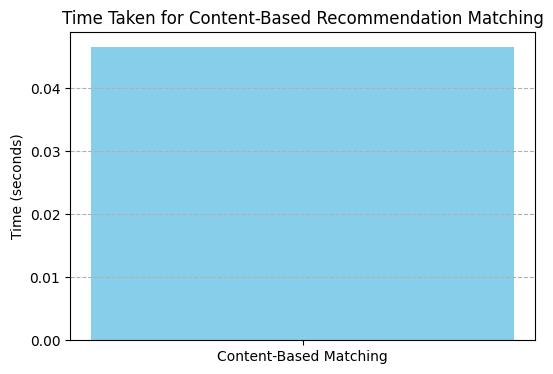

In [61]:
start_time = time.time()
recommended_games = get_content_based_recommendations(game_to_recommend)
end_time = time.time()

if game_to_recommend in games_df['Name'].values:
    print(f"Rekomendasi game yang mirip dengan '{game_to_recommend}':")
    print(get_content_based_recommendations(game_to_recommend))
else:
    print(f"Game '{game_to_recommend}' tidak ditemukan dalam dataset.")

matching_time = end_time - start_time

print(f"Time taken for content-based matching: {matching_time:.4f} seconds")

# Visualize the matching time
plt.figure(figsize=(6, 4))
plt.bar(['Content-Based Matching'], [matching_time], color='skyblue')
plt.ylabel('Time (seconds)')
plt.title('Time Taken for Content-Based Recommendation Matching')
plt.grid(axis='y', linestyle='--')
plt.show()

## Model Development using Deep Content Filtering

Meskipun dataset ini tidak memiliki data interaksi pengguna (seperti rating atau playtime per user) yang ideal untuk model seperti RecommenderNet, kita bisa mengadaptasi idenya.

RecommenderNet biasanya menggabungkan embedding dari pengguna dan item. Karena tidak ada pengguna, kita bisa mencoba membuat embedding hanya untuk item (game) berdasarkan fitur kontennya.

Ide:
1. Buat layer embedding untuk setiap fitur kategorikal (misalnya, Player based, Tag 1, Tag 2, Tag 3).
2. Buat layer input untuk fitur numerik (misalnya, Required age, Supported languages, dll.).
3. Gabungkan embedding dan input numerik.
4. Lewatkan melalui beberapa dense layer.
5. Output layer bisa berupa embedding vektor game. Kemiripan antar game kemudian dihitung dari embedding ini.

In [51]:
# Fitur kategorikal yang akan di-encode
categorical_features = ['Player based', 'Steam Achievements', 'Family Sharing',
                        'Full controller support', 'Tag 1', 'Tag 2', 'Tag 3',
                        'Windows', 'Mac', 'Linux'] # Include platform features

# Salinan data untuk encoding
games_encoded = games_df.copy()

# Dictionary untuk menyimpan encoder
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    # Handle potential NaN values that might appear after drops/preprocessing
    games_encoded[col] = games_encoded[col].astype(str) # Ensure all are strings before encoding
    games_encoded[col] = le.fit_transform(games_encoded[col])
    label_encoders[col] = le # Store the encoder

In [52]:
# Fitur numerik
numerical_features = ['Required age', 'Supported languages', 'Full audio languages', 'Average playtime forever']

# Normalisasi fitur numerik (Opsional tapi direkomendasikan)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
games_encoded[numerical_features] = scaler.fit_transform(games_encoded[numerical_features])

In [53]:
# Buat input layers
input_layers = []
embedding_layers = []
dense_inputs = []

# Input dan embedding untuk fitur kategorikal
for col in categorical_features:
    num_unique_values = len(label_encoders[col].classes_)
    embedding_dim = max(2, min(50, num_unique_values // 2)) # Heuristik sederhana untuk dimensi embedding

    input_layer = keras.Input(shape=(1,), name=f'input_{col}')
    # Modify the layer name to replace spaces with underscores
    cleaned_col_name = col.replace(" ", "_")
    embedding_layer = layers.Embedding(input_dim=num_unique_values, output_dim=embedding_dim, name=f'embedding_{cleaned_col_name}')(input_layer)
    flatten_layer = layers.Flatten()(embedding_layer)

    input_layers.append(input_layer)
    embedding_layers.append(flatten_layer)

# Input untuk fitur numerik
for col in numerical_features:
    input_layer = keras.Input(shape=(1,), name=f'input_{col}')
    input_layers.append(input_layer)
    dense_inputs.append(input_layer)

# Gabungkan semua embedding dan input numerik
# Pastikan embedding_layers dan dense_inputs tidak kosong
if embedding_layers and dense_inputs:
    concat_layer = layers.concatenate(embedding_layers + dense_inputs)
elif embedding_layers:
     concat_layer = layers.concatenate(embedding_layers)
elif dense_inputs:
    concat_layer = layers.concatenate(dense_inputs)
else:
    raise ValueError("Tidak ada fitur yang tersedia untuk model.")

# Dense layers (arsitektur mirip RecommenderNet)
x = layers.Dense(128, activation='relu')(concat_layer)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Output layer: Representasi embedding game (misalnya, 32 dimensi)
game_embedding = layers.Dense(32, activation='linear', name='game_embedding')(x) # Linear activation for embedding

# Model
recommender_model = keras.Model(inputs=input_layers, outputs=game_embedding)

recommender_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_Player based  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Steam         │ (None, 1)         │          0 │ -                 │
│ Achievements        │                   │            │                   │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Family        │ (None, 1)         │          0 │ -                 │
│ Sharing             │                   │            │                   │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Full          │ (None, 1)         │          0 │ -                 │
│ controller support  │                   │            │                   │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Tag 1         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Tag 2         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Tag 3         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Windows       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Mac           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Linux         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_Player_b… │ (None, 1, 2)      │          4 │ input_Player      │
│ (Embedding)         │                   │            │ based[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_Steam_Ac… │ (None, 1, 2)      │          4 │ input_Steam       │
│ (Embedding)         │                   │            │ Achievements[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_Family_S… │ (None, 1, 2)      │          4 │ input_Family      │
│ (Embedding)         │                   │            │ Sharing[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_Full_con… │ (None, 1, 2)      │          4 │ input_Full        │
│ (Embedding)         │                   │            │ controller        │
│                     │                   │            │ support[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_Tag_1     │ (None, 1, 50)     │     16,900 │ input_Tag 1[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 87,996 (343.73 KB)

 Trainable params: 87,996 (343.73 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Mendapatkan embedding untuk semua game
# Siapkan input data dalam format yang sesuai untuk model
model_inputs = {}
for col in categorical_features + numerical_features:
     # Ensure correct data type for model input
    if col in categorical_features:
        model_inputs[f'input_{col}'] = games_encoded[col].values
    else: # numerical_features
        model_inputs[f'input_{col}'] = games_encoded[col].values

# Ubah dictionary input menjadi list sesuai urutan input_layers di model
ordered_model_inputs = [model_inputs[input_layer.name] for input_layer in recommender_model.inputs]


game_embeddings = recommender_model.predict(ordered_model_inputs)

print("Bentuk matriks embedding game:", game_embeddings.shape)

641/641 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Bentuk matriks embedding game: (20499, 32)


In [55]:
# Menghitung kemiripan kosinus antar embedding game
cosine_sim_deep = cosine_similarity(game_embeddings, game_embeddings)

print("Bentuk matriks kemiripan kosinus (Deep):", cosine_sim_deep.shape)

Bentuk matriks kemiripan kosinus (Deep): (20499, 20499)


In [56]:
# Fungsi untuk mendapatkan rekomendasi menggunakan embedding dari model "Deep"
def get_deep_content_based_recommendations(game_name, cosine_sim=cosine_sim_deep, games_df=games_df, indices=indices):
    # Mendapatkan indeks dari game yang namanya cocok
    # Pastikan indeks Series menggunakan index dari games_df, bukan games_encoded
    idx = indices[game_name]

    # Mendapatkan skor kemiripan dari semua game dengan game ini
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Mengurutkan game berdasarkan skor kemiripan secara menurun
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mengambil skor dari 10 game paling mirip (kecuali game itu sendiri)
    sim_scores = sim_scores[1:11]

    # Mendapatkan indeks game
    game_indices = [i[0] for i in sim_scores]

    # Mengembalikan nama game yang paling mirip
    return games_df['Name'].iloc[game_indices]

In [57]:
# Contoh penggunaan: Mendapatkan rekomendasi menggunakan embedding dari model "Deep"
if game_to_recommend in games_df['Name'].values:
    print(f"\nRekomendasi game yang mirip dengan '{game_to_recommend}' menggunakan Deep Content-Based:")
    print(get_deep_content_based_recommendations(game_to_recommend))
else:
    print(f"Game '{game_to_recommend}' tidak ditemukan dalam dataset.")


Rekomendasi game yang mirip dengan 'Artificial Life Simulator' menggunakan Deep Content-Based:
17520    Mysteria of the World: The forest of Death
11533                                       Our Way
8051                                       Janus VR
292                                        Chosen 2
12342                            骸亡禁决：Skeleton King
3726                                 Delta Manifold
10064                               Virtual Cottage
2548                                      Otherside
4811                                  Blox 3D World
3528                         MAP GAME: Or Something
Name: Name, dtype: object
